# Importações

In [1]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [3]:
devices = tf.config.list_physical_devices()
devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("GPU disponível!")
else:
    print("GPU não disponível.")

GPU disponível!


# Organizando as Imagens em Disco

In [5]:
path_train = 'dados/dados/EuroSAT/2750/Training/'
path_test = 'dados/dados/EuroSAT/2750/Test/'

In [6]:
class_names = [name for name in os.listdir(path_train) if name != '.DS_Store']
class_names

['River',
 'Forest',
 'Residential',
 'SeaLake',
 'HerbaceousVegetation',
 'Highway',
 'Pasture',
 'AnnualCrop',
 'PermanentCrop',
 'Industrial']

# Formatação das Imagens a Partir da Pasta de Imagens no Disco

In [7]:
def gera_dataset(directory,
                 image_size,
                 batch_size,
                 validation_split,
                 subset,
                 class_names,
                 labels = 'inferred',
                 label_mode = 'int',
                 shuffle = True):

    data = image_dataset_from_directory(directory,
                                        labels = labels,
                                        label_mode= label_mode,
                                        class_names= class_names,
                                        color_mode= 'rgb',
                                        batch_size= batch_size,
                                        image_size= image_size,
                                        shuffle= shuffle,
                                        seed = 0,
                                        validation_split= validation_split,
                                        subset= subset,
                                        interpolation= 'bilinear',
                                        follow_links= False)

    return data

In [8]:
image_size = (64, 64)

In [9]:
batch_size = 64

In [10]:
data_train = gera_dataset(path_train, image_size, batch_size, 0.17, 'training', class_names)

Found 24300 files belonging to 10 classes.
Using 20169 files for training.


In [11]:
data_val = gera_dataset(path_train, image_size, batch_size, 0.17, 'validation', class_names)

Found 24300 files belonging to 10 classes.
Using 4131 files for validation.


In [12]:
data_test = gera_dataset(path_test, image_size, batch_size, None, None, class_names)

Found 2700 files belonging to 10 classes.


In [13]:
print(f'Number of Train Batchs: {tf.data.experimental.cardinality(data_train).numpy()}')
print(f'Number of Validation Batchs: {tf.data.experimental.cardinality(data_val).numpy()}')
print(f'Number of Test Batchs: {tf.data.experimental.cardinality(data_test).numpy()}')

Number of Train Batchs: 316
Number of Validation Batchs: 65
Number of Test Batchs: 43


# Visualizando as Imagens

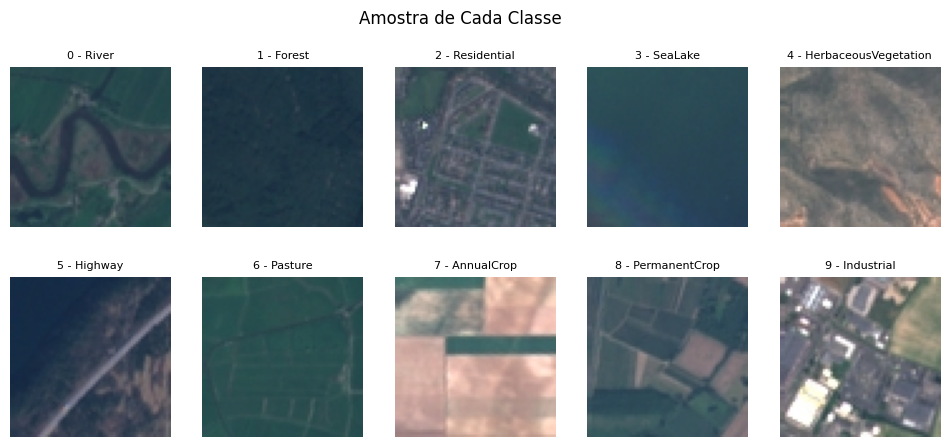

In [14]:
nrow, ncol = 2, 5

_, ax = plt.subplots(nrow, ncol, figsize = (12, 5))
plt.suptitle('Amostra de Cada Classe')
for images, label in data_train.take(1):
    for i in range(10):
        for j in range(len(label)):
            if label[j] == i:
                ax[i//ncol, i%ncol].imshow(images[j].numpy().astype('uint8'))
                ax[i//ncol, i%ncol].set_title(f'{label[j].numpy()} - {class_names[label[j].numpy()]}', fontsize = 8)
                ax[i//ncol, i%ncol].axis('off')
                break
    break

# Arquitetura e Construção do Modelo

In [15]:
def cria_modelo(input_shape, num_classes):

    inputs = tf.keras.Input(shape = input_shape)
    x = Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    previous_block_activation = x
    
    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(3, strides= 2, padding= 'same')(x)
        residual = tf.keras.layers.Conv2D(size, 1, strides= 2, padding= 'same')(previous_block_activation)
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding= 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation = activation)(x)

    return tf.keras.Model(inputs, outputs)

In [16]:
model = cria_modelo(input_shape= image_size + (3,), num_classes= 10)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 64, 64, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 32, 32,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 32, 32,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 16, 16,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ separable_conv2d

 Total params: 2,740,290 (10.45 MB)

 Trainable params: 2,732,002 (10.42 MB)

 Non-trainable params: 8,288 (32.38 KB)

# Callbacks para Monitorar e Salvar a Melhor Versão do Modelo

In [18]:
callbacks = [
    tf.keras.callbacks.CSVLogger('modelo/' + 'historico_treino.csv', separator= ',', append = True),
    tf.keras.callbacks.ModelCheckpoint(
        'modelo/keras_checkpoint/best_model.keras',
        save_best_only= True,
        monitor = 'val_loss',
        mode = 'min'
    )
]

# Compilação do Modelo

In [19]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 5e-3),
              loss = 'SparseCategoricalCrossentropy',
              metrics= ['accuracy'])

# Treinamento do Modelo

In [20]:
epochs = 30

In [21]:
%%time

with tf.device('/GPU:0'):

    history = model.fit(data_train,
                        epochs= epochs,
                        callbacks = callbacks,
                        validation_data= data_val)

Epoch 1/30


I0000 00:00:1734181771.985416   19175 service.cc:145] XLA service 0x7f82a8003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734181771.985481   19175 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6


  3/316 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.1493 - loss: 3.2499   

I0000 00:00:1734181783.027427   19175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4760 - loss: 1.6112 

I0000 00:00:1734181802.253952   19491 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_322', 372 bytes spill stores, 372 bytes spill loads

I0000 00:00:1734181802.330228   19498 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_322', 68 bytes spill stores, 68 bytes spill loads

I0000 00:00:1734181803.717273   19525 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_322', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1734181804.176591   19529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_322', 112 bytes spill stores, 112 bytes spill loads

I0000 00:00:1734181804.226428   19533 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_322', 416 bytes spill stores, 344 bytes spill loads



316/316 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.4764 - loss: 1.6099 - val_accuracy: 0.4319 - val_loss: 1.5422
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.7173 - loss: 0.7922 - val_accuracy: 0.3048 - val_loss: 4.1202
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.7805 - loss: 0.6432 - val_accuracy: 0.6422 - val_loss: 1.4994
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8585 - loss: 0.4158 - val_accuracy: 0.7124 - val_loss: 0.9931
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8896 - loss: 0.3264 - val_accuracy: 0.8598 - val_loss: 0.4276
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9050 - loss: 0.2849 - val_accuracy: 0.4081 - val_loss: 3.9080
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9126 - loss: 0.2639 - val_accuracy: 0.7819 - val_loss: 0.7716
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9083 - loss: 0.2698 - val_accurac

# Avaliação do Modelo

In [24]:
def plot_history(history):
    _, ax = plt.subplots(1, 2, figsize = (14, 3.7))

    plt.suptitle('Curva de Aprendizagem')
    ax[0].plot(history.history['loss'], color= 'slateblue', label = 'Erro de Treino')
    ax[0].plot(history.history['val_loss'], color= 'orangered', label= 'Erro de Validação', alpha= .7)
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(history.history['accuracy'], color= 'slateblue', label = 'Acurácia em Treino')
    ax[1].plot(history.history['val_accuracy'], color= 'orangered', label= 'Acurácia em Validação', alpha= .7)
    ax[1].legend()
    ax[1].set_ylabel('Acurácia')
    ax[1].set_xlabel('Epoch')

    plt.show()

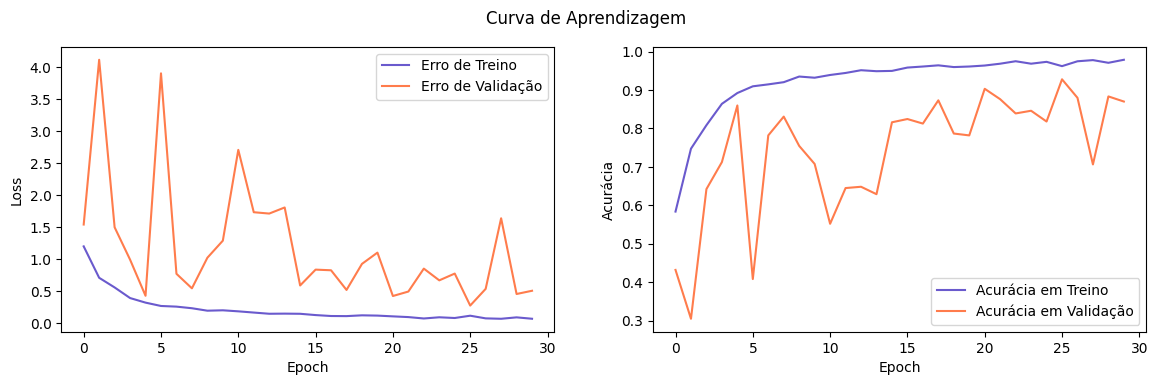

In [25]:
plot_history(history)

In [34]:
modelo_carregado = tf.keras.models.load_model('modelo/keras_checkpoint/best_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Previsões Corretas: 0 (0%)


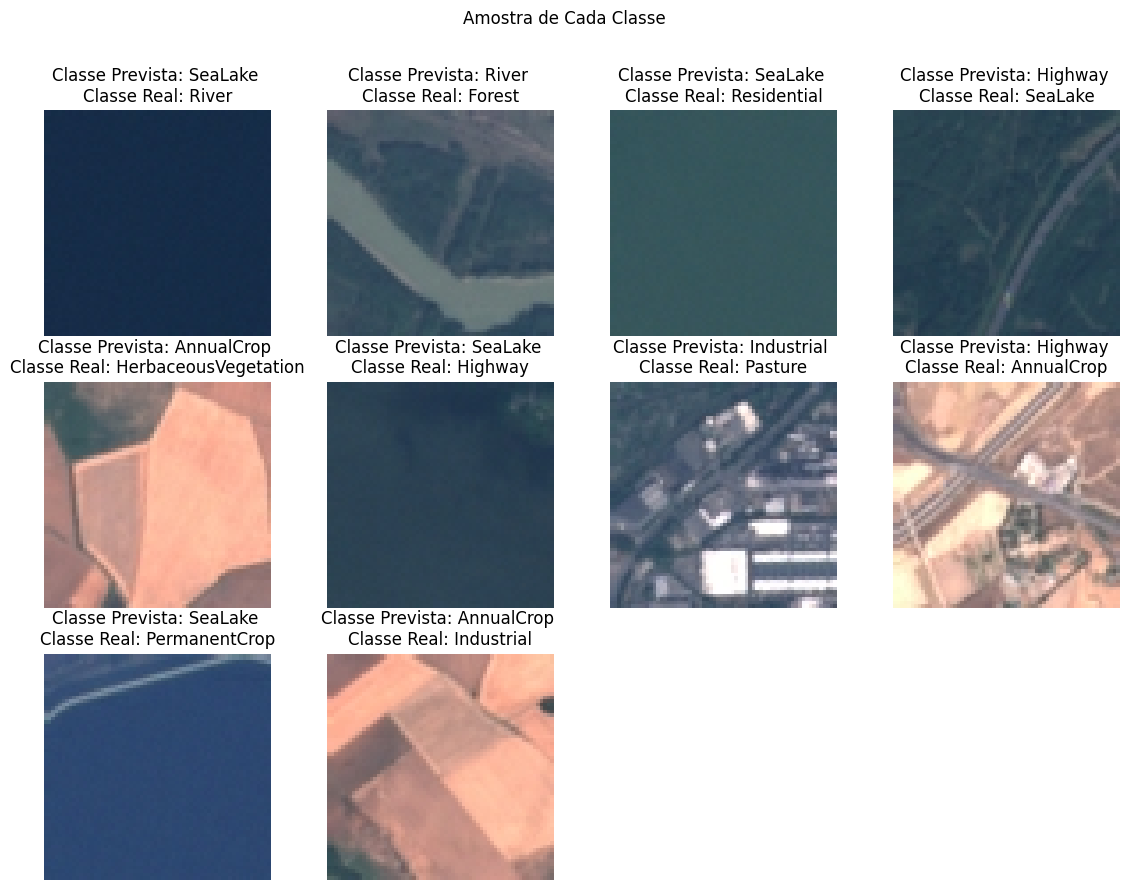

In [35]:
nrow, ncol = 3, 4

_, ax = plt.subplots(nrow, ncol, figsize = (14, 10))
for axis in ax.ravel()[-2:]:
    axis.set_axis_off()

plt.suptitle('Amostra de Cada Classe')
for images, laabel in data_test.take(1):
    correct = 0
    for i in range(10):
        for j in range(len(label)):
            if label[j] == i:
                img_array = np.expand_dims(images[j].numpy(), 0)
                predicted = modelo_carregado.predict(img_array)
                predicted_class = class_names[np.argmax(predicted[0])]
                correct += 1 if predicted_class == class_names[label[j].numpy()] else 0
                ax[i//ncol, i%ncol].imshow(images[j].numpy().astype('uint8'))
                ax[i//ncol, i%ncol].set_title(f'Classe Prevista: {predicted_class} \nClasse Real: {class_names[label[j].numpy()]}')
                ax[i//ncol, i%ncol].axis('off')
                break
    break

print(f'\nPrevisões Corretas: {correct} ({correct*10}%)')

In [36]:
def calcula_acuracia(model, data):
    
    if isinstance(data, tf.data.Dataset):
        
        input_, target_ = zip(*[(x[0], x[1]) for x in data.as_numpy_iterator()])
        input_, target_ = np.array(input_), np.array(target_)
        predictions = np.array([np.argmax(model.predict(np.expand_dims(x, 0))) for x in input_])
    
    elif isinstance(data, list):
        if len(data) == 3:
            input_, target_, predictions = data
        elif len(data) == 2:
            input_, target_ = data
            predictions = np.array([np.argmax(model.predict(np.expand_dims(x, 0))) for x in input_])
        else:
            raise ValueError("Somente as dimensões 2 e 3 são permitidas para objetos de dados")
    else:
        raise ValueError("Objeto desconhecido: use list ou objeto tf.data.Dataset")
    
    accuracy = np.sum(target_ == predictions) / len(target_)
    
    print("\nAcurácia Final do Modelo: {:.3f}".format(accuracy))
    
    return accuracy

In [ ]:
%%time

acc = calcula_acuracia(modelo_carregado, data_test.unbatch())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [38]:
print(f'Acurácia Final do Modelo: {acc:.3f}')

Acurácia Final do Modelo: 0.934
